In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

# Objective

The goal of this project is to develop a machine learning model that accurately predicts the health status of automotive engines based on sensor and diagnostic data. Specifically, the model classifies engines as either "Good Health" (1) or "Bad Health" (0).

By providing early and reliable predictions of engine health, this system aims to:

- Enable predictive maintenance and reduce unexpected breakdowns,

- Optimize service scheduling and minimize downtime,

- Lower maintenance costs by identifying issues before they escalate,

- Improve vehicle safety and performance

- Enhance decision-making for fleet managers, service providers, or end users.

This solution can be integrated into existing automotive diagnostic systems or fleet management platforms to support proactive maintenance strategies, improve customer satisfaction, and ultimately extend the lifecycle of vehicles.

# Data Loading

In [2]:
df=pd.read_csv('engine_data.csv')
df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


# Data Splitting

In [3]:
x=df.drop('Engine Condition',axis=1)
y=df['Engine Condition']

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,      # 20% test, 80% train
    random_state=42,    # optional, for reproducibility
    stratify=y          # keeps the class distribution balanced (recommended)
)

# Data Understanding

In [5]:
df=x_train.copy(deep=True)

In [6]:
df.shape

(15628, 6)

Null checks

In [7]:
(df.isnull().sum()/len(df))*100

,0
Engine rpm,0.0
Lub oil pressure,0.0
Fuel pressure,0.0
Coolant pressure,0.0
lub oil temp,0.0
Coolant temp,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15628 entries, 16957 to 9964
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        15628 non-null  int64  
 1   Lub oil pressure  15628 non-null  float64
 2   Fuel pressure     15628 non-null  float64
 3   Coolant pressure  15628 non-null  float64
 4   lub oil temp      15628 non-null  float64
 5   Coolant temp      15628 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 854.7 KB


In [9]:
df.describe()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
count,15628.000000,15628.000000,15628.000000,15628.000000,15628.000000,15628.000000
mean,792.261710,3.307509,6.651980,2.341039,77.650334,78.432762
std,267.342976,1.024962,2.761860,1.040753,3.121914,6.220440
min,61.000000,0.003384,0.003187,0.002483,71.321974,62.445955
25%,594.000000,2.516444,4.910082,1.603476,75.718594,73.905583
50%,748.000000,3.164588,6.194226,2.173164,76.816708,78.340971
75%,934.000000,4.061431,7.735893,2.850974,78.077116,82.908178
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912


Engine rpm has a very high variability which is evident from the standard deviation.

Checking target column

In [10]:
y_train.value_counts()

,count
Engine Condition,
1,9854
0,5774


1: good condition

0: bad condition

36% of the engines are in bad condition.

In [11]:
y_train.isnull().sum()

np.int64(0)

# Exploratory Data Analysis

In [12]:
cols=df.columns
len(cols)

6

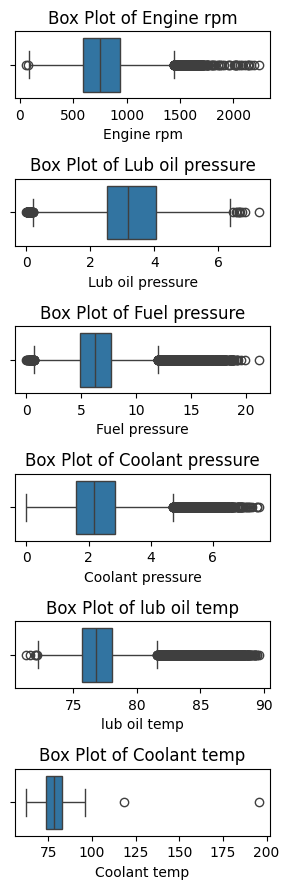

In [13]:
fig, axes = plt.subplots(len(cols), 1, figsize=(3, 1.5 * len(cols)))
for i, col in enumerate(cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()

- Engine RPM:

The distribution is slightly right-skewed, with a long tail of high RPM values.

There are several outliers beyond ~1500 RPM, indicating occasional spikes in engine speed.

Majority of values lie between ~500 and ~1000 RPM.

- Lub Oil Pressure:

Fairly symmetrical distribution with a slight right skew.

Outliers are present on both low and high ends, but more prominent at higher values (>6 bar).

Central tendency is around 3–4 bar.

- Fuel Pressure:

Noticeably right-skewed with a heavy concentration of values between 5–9 bar.

Numerous high-value outliers, indicating fuel spikes or irregular pressure events.

The long tail suggests some potential for extreme values which may need further investigation.

- Coolant Pressure:

Strong right-skewed distribution and some high-value outliers.

Central range is between 1.5 and 3 bar.

- Lub Oil Temperature:

Strong right skew with a tight interquartile range (~74–80°C).

A significant number of high-end outliers, indicating potential overheating events.

- Coolant Temperature:

Mostly concentrated around 75–90°C with some extreme outliers (~125°C and ~200°C).

These high-end values could be anomalies or signs of overheating issues needing inspection.



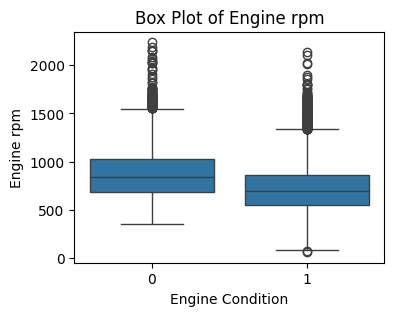

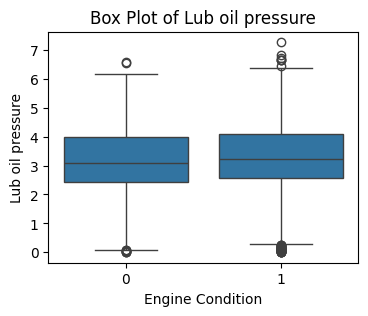

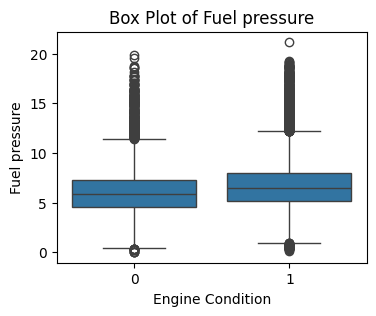

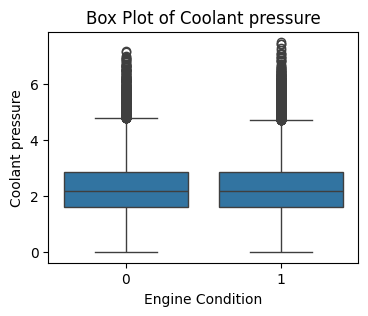

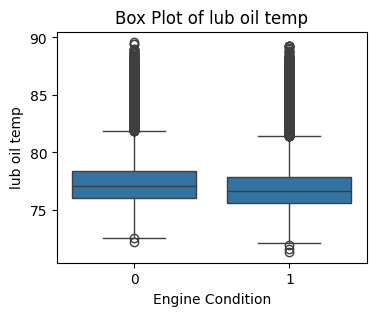

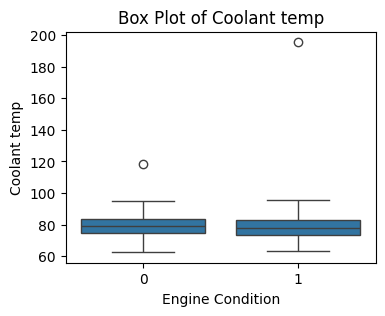

In [14]:
df['Engine Condition']=y_train
for col in cols:
    plt.figure(figsize=(4, 3))
    sns.boxplot(data=df, x='Engine Condition', y=col)
    plt.title(f'Box Plot of {col}')
    plt.show()

- Engine RPM vs. Condition:

Median RPM is slightly lower for engines in good condition (1) suggesting that healthy engines tend to idle more consistently within a controlled range.

Engines in bad condition (0) exhibit a higher RPM spread and higher median, possibly indicating inefficient idle regulation or aggressive corrective behavior by the engine’s control system (i.e., overcompensation in response to internal issues such as misfires or pressure drops).

Additionally, a high number of outliers is observed in both conditions, implying that engine RPM fluctuates significantly across the dataset, regardless of engine health — potentially due to varying driving conditions or load demands.

- Lub Oil Pressure vs. Condition:

Distributions are very similar across both engine conditions.

Slightly more low-pressure outliers in bad condition engines, hinting that insufficient lubrication issues may contribute to poor engine health.

Median pressure is marginally lower for bad engines.

The high variability and lower pressure outliers in bad engines may be due to oil pump issues

- Fuel Pressure vs. Condition:

Both conditions show right-skewed distributions with many high-end outliers.

Engines in good condition tend to have a slightly higher median fuel pressure, suggesting efficient fuel injection is key to healthy engine operation.

However, the similarity in spread implies fuel pressure alone isn’t a clear-cut indicator of engine condition.

- Coolant Pressure vs. Condition:

Almost identical distribution across both groups.

Consistently high number of outliers above 5 bar in both, suggesting coolant system pressure irregularities are common and not necessarily linked to engine health.

- Lub Oil Temperature vs. Condition:

Nearly identical distributions.

Bad engines actually show higher values at the 25th and 75th percentiles, meaning a larger portion of bad engines run at a slightly elevated lubricant temperature compared to good ones.

However, good engines have slightly more outliers at both ends, showing more variability.

Bad engines might be consistently operating at a higher baseline temperature across the mid-range, possibly due to frictional inefficiencies, poor cooling, or degraded oil quality.

Good engines, while stable at the core (slightly lower IQR), occasionally spike higher or lower, maybe due to dynamic operations, load variation, or even sensor precision in better-maintained systems.


- Coolant Temperature vs. Condition:

Medians and IQRs are quite similar.

However, extreme outliers (e.g., ~200°C) appear in both groups, possibly due to sensor glitches or rare overheating events.

No significant differentiation between engine states.



High and unstable RPM indicates erratic engine behavior due to inconsistent lubrication of the engine parts, hindering smooth movement. The insufficient lubrication is implied by the low lubricant oil pressure. So there is insufficient lubricant oil circulation. The rising internal frictions between the engine parts are also increasing the lubricant oil temperature. The small amount of oil that is circulating ends up absorbing a disproportionate amount of the heat caused by internal frictions — and since there’s less oil volume to absorb it, the temperature of that oil rises.

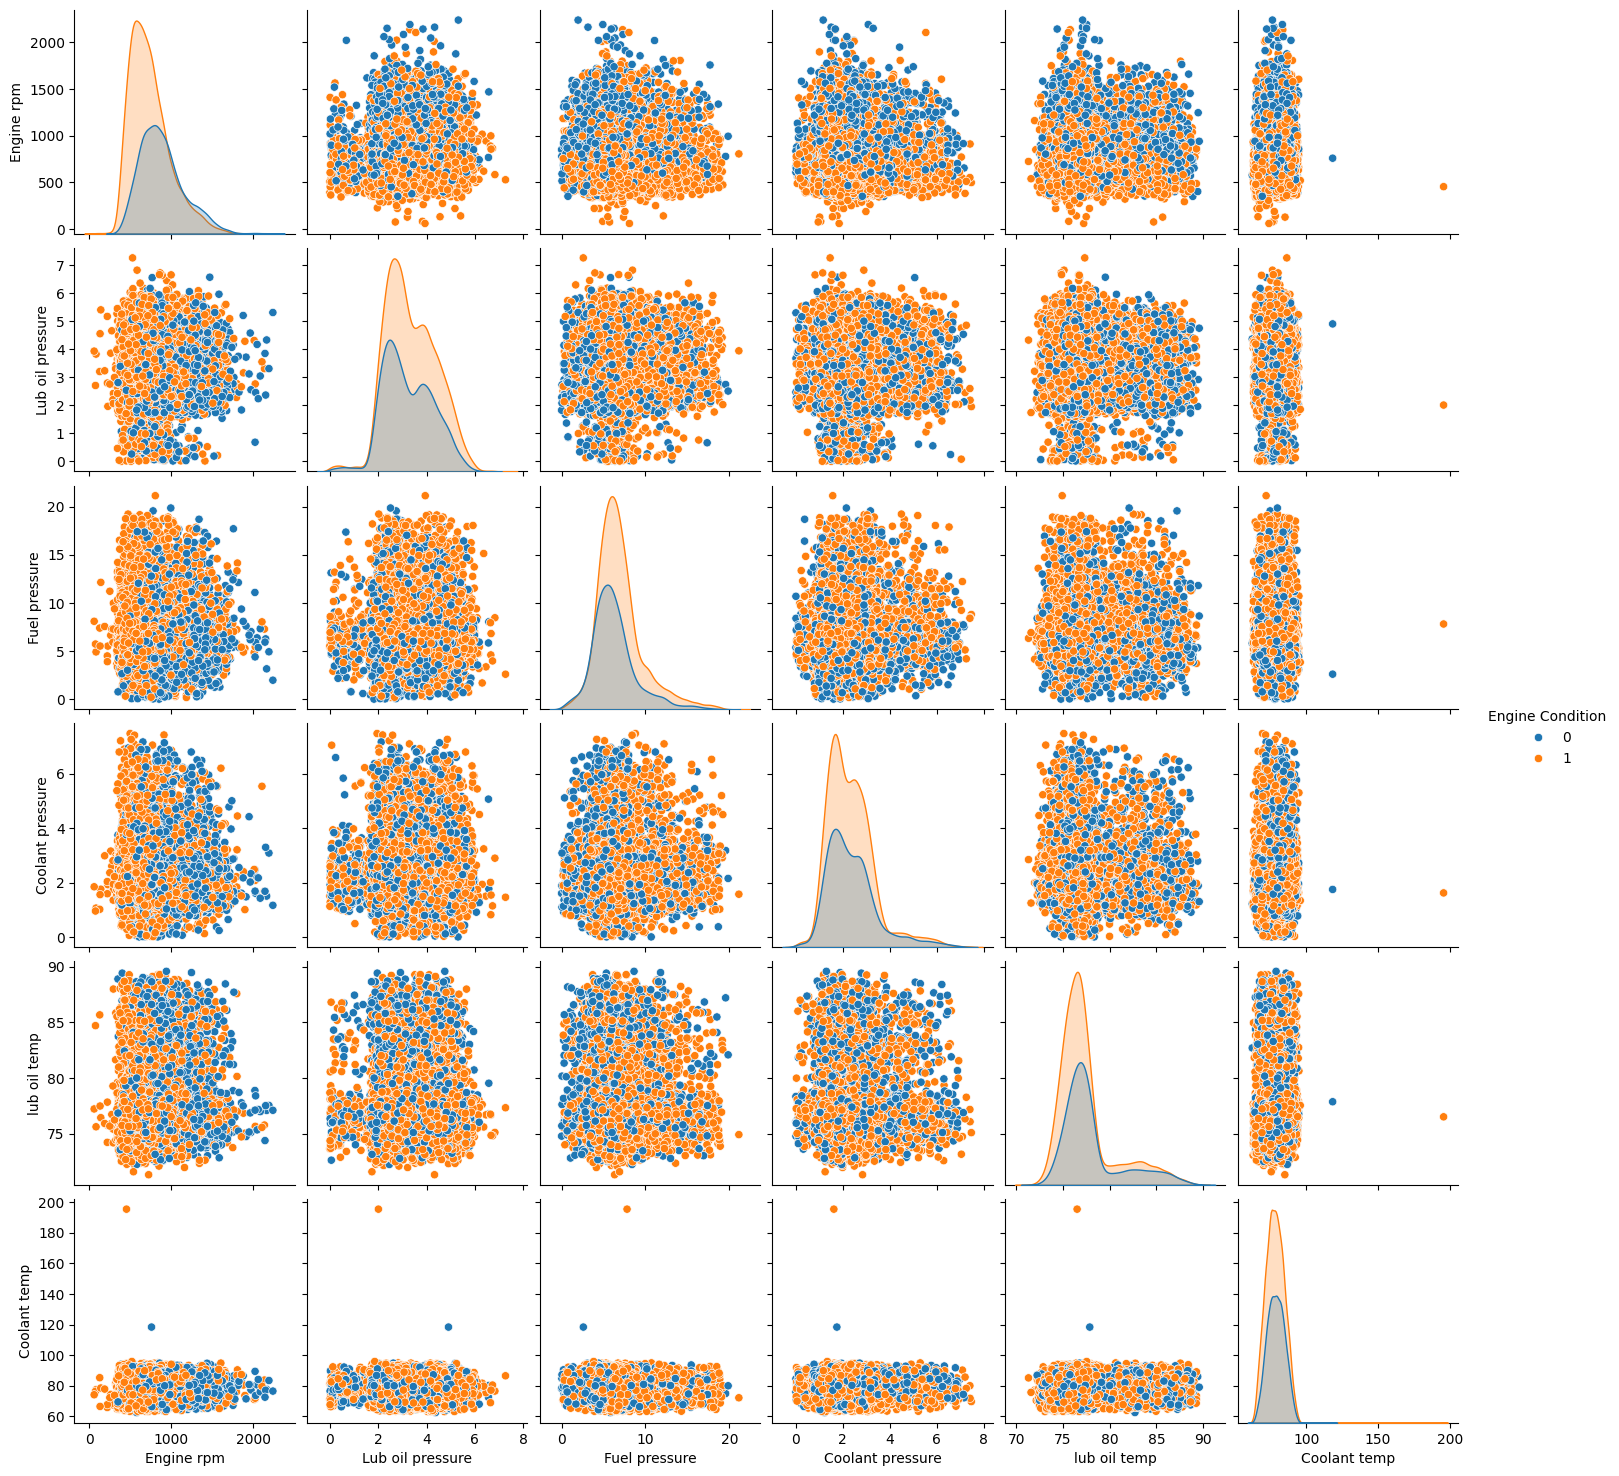

In [15]:
sns.pairplot(df, hue="Engine Condition")

For lower values of Engine RPM and higher values of Fuel pressure, the engine conditions are mostly good.

For lower values of Engine RPM and higher values of lubricant oil pressure, the engine conditions are mostly good.

Many good engines have lower values of lubricant oil temperaure and higher values of lubricant oil pressure.

The engine RPM appears to be the most prominent indicator distinguishing good and bad engines. Too high Engine rpm is a strong indicator of engine health deterioration. Also, fuel pressure is another strong indicator. Engines with good health should have high fuel pressure.

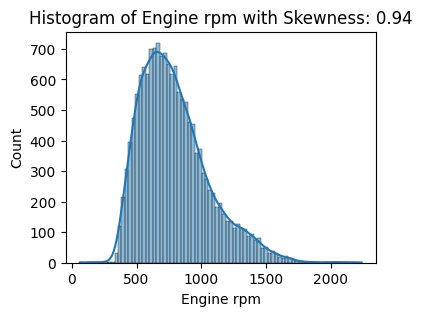

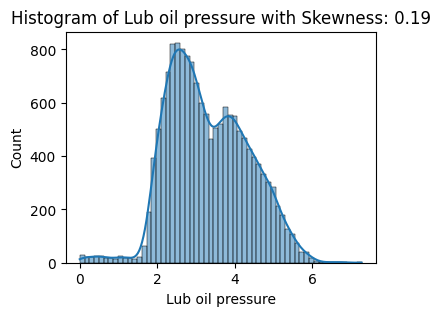

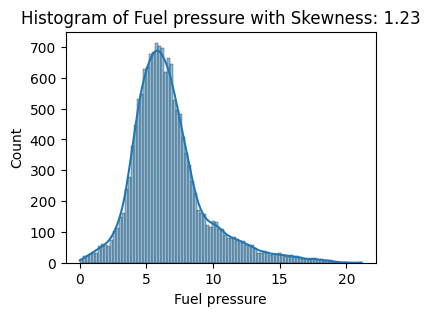

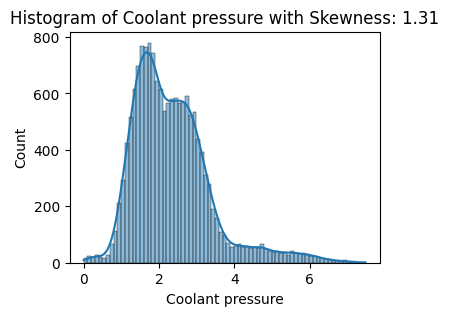

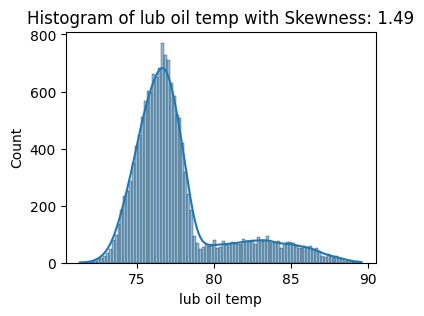

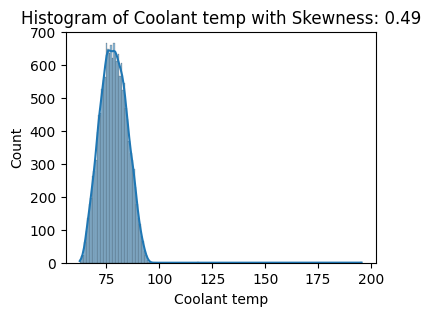

In [16]:
high_positive_skew1=[]
high_negative_skew1=[]
low_to_moderate_skew1=[]
for col in cols:
    # Calculate skewness
    skewness = df[col].skew()

    # Classify columns based on skewness
    if skewness > 1.3:
        high_positive_skew1.append(col)
    elif skewness < -1.3:
        high_negative_skew1.append(col)
    else:
        low_to_moderate_skew1.append(col)

    # Print histogram and skewness value
    plt.figure(figsize=(4, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram of {col} with Skewness: {skewness:.2f}")
    plt.show()

In [17]:
cols

Index(['Engine rpm', 'Lub oil pressure', 'Fuel pressure', 'Coolant pressure',
       'lub oil temp', 'Coolant temp'],
      dtype='object')

In [18]:
cols

Index(['Engine rpm', 'Lub oil pressure', 'Fuel pressure', 'Coolant pressure',
       'lub oil temp', 'Coolant temp'],
      dtype='object')

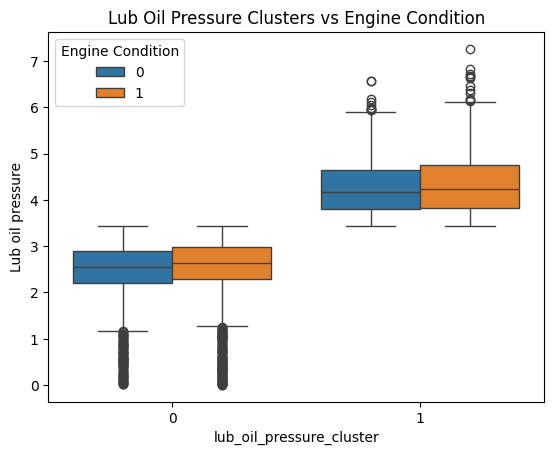

In [19]:
from sklearn.cluster import KMeans

df2=df.copy(deep=True)

# Apply KMeans to Lub oil temp
kmeans = KMeans(n_clusters=2, random_state=42)
df2['lub_oil_pressure_cluster'] = kmeans.fit_predict(df2[['Lub oil pressure']])

# Visualize cluster vs Engine Condition
sns.boxplot(data=df2, x='lub_oil_pressure_cluster', y='Lub oil pressure', hue='Engine Condition')
plt.title('Lub Oil Pressure Clusters vs Engine Condition')
plt.show()

In [20]:
pd.crosstab(df2['lub_oil_pressure_cluster'], df2['Engine Condition'])

Engine Condition,0,1
lub_oil_pressure_cluster,,
0,3424,5560
1,2350,4294


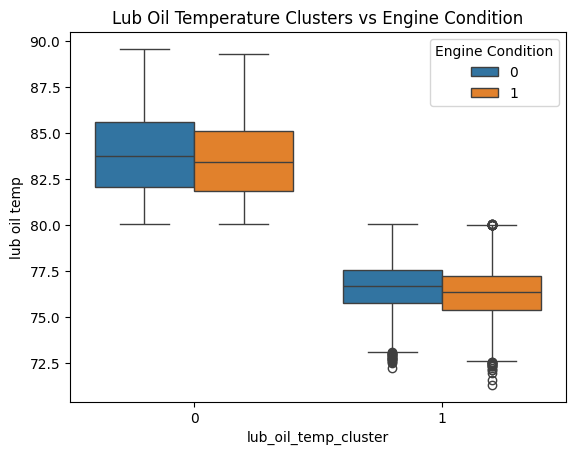

In [21]:
# Apply KMeans to Lub oil temp
kmeans = KMeans(n_clusters=2, random_state=42)
df2['lub_oil_temp_cluster'] = kmeans.fit_predict(df2[['lub oil temp']])

# Visualize cluster vs Engine Condition
sns.boxplot(data=df2, x='lub_oil_temp_cluster', y='lub oil temp', hue='Engine Condition')
plt.title('Lub Oil Temperature Clusters vs Engine Condition')
plt.show()

In [22]:
pd.crosstab(df2['lub_oil_temp_cluster'], df2['Engine Condition'])

Engine Condition,0,1
lub_oil_temp_cluster,,
0,1117,1524
1,4657,8330


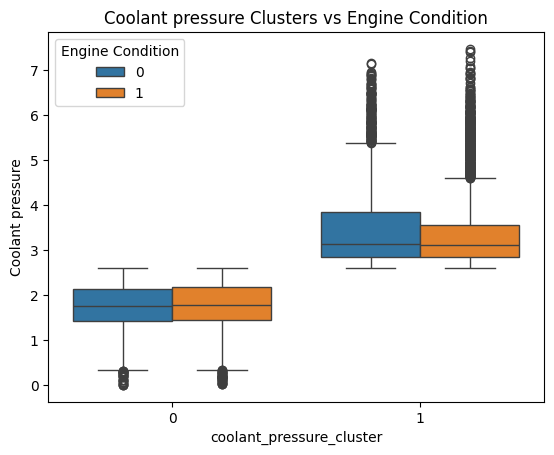

In [23]:
# Apply KMeans to coolant pressure
kmeans = KMeans(n_clusters=2, random_state=42)
df2['coolant_pressure_cluster'] = kmeans.fit_predict(df2[['Coolant pressure']])

# Visualize cluster vs Engine Condition
sns.boxplot(data=df2, x='coolant_pressure_cluster', y='Coolant pressure', hue='Engine Condition')
plt.title('Coolant pressure Clusters vs Engine Condition')
plt.show()

In [24]:
pd.crosstab(df2['coolant_pressure_cluster'], df2['Engine Condition'])

Engine Condition,0,1
coolant_pressure_cluster,,
0,3768,6571
1,2006,3283


Correlation matrix

<Axes: >

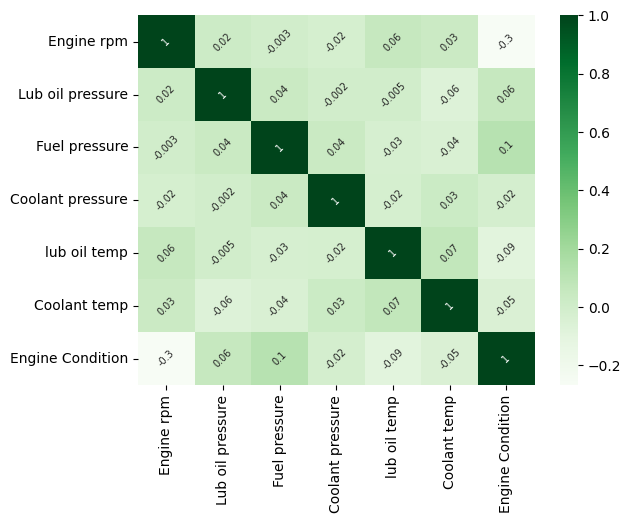

In [25]:
sns.heatmap(df.corr(),annot=True,fmt='.1g', annot_kws={"rotation": 45,"size": 7},cmap='Greens')

# Derived Features

Each interaction term was chosen based on mechanical principles, not just statistical correlations. These combinations reflect load, lubrication efficiency, and thermal stress — all of which are critical in engine health diagnosis

- Feature 1: rpm_x_oil_temp

Formula: Engine rpm × Lub oil temp

Physical Meaning:
High RPM = high engine speed and High lubricant temp = internal friction + engine heat.
Together, they reflect how hard the engine is working (load/stress)

Bad engines may heat up faster under high RPM due to inefficiencies or worn parts.

- Feature 2: oil_pressure_per_rpm

Formula: Lub oil pressure / Engine rpm

Physical Meaning: Oil pressure should rise with RPM to maintain proper lubrication.Low oil pressure per unit RPM = poor lubrication at high speeds

A bad engine might have low oil pressure relative to RPM, indicating wear, leaks, or pump issues.

- Feature 3: total_thermal_stress

Formula: Lub oil temp × Coolant temp

Physical Meaning: Both temperatures rising = engine under thermal load
Multiplied, they represent compound heat stress in the lubrication + cooling systems. Engines running hotter than normal under normal conditions may be degrading or close to failure.

- Feature 4: fuel_to_coolant_ratio

Formula: Fuel pressure / Coolant pressure

Physical Meaning: High fuel pressure could mean over-fueling. Low coolant pressure could mean a cooling issue. A high ratio suggests overdrive or cooling inefficiency, which can hurt engine performance

Engines with inefficient cooling may overcompensate with fuel pressure — this ratio might help spot that.

- Feature 5: friction_heat_product

Formula: Lub oil pressure × Lub oil temp

Physical Meaning: High pressure and high temp can indicate increased internal resistance or friction. May also indicate oil is working harder to maintain flow due to aging parts

A struggling engine may show high oil pressure and high temperature as it compensates for internal degradation.

- Feature 6: coolant_temp_per_rpm

Formula: Coolant temp / Engine rpm

Physical Meaning: High coolant temp at low RPM = inefficient cooling or overheating. Normally, coolant temp should stabilize or drop with increased RPM (better airflow/pumping)

Bad engines may overheat even at lower RPMs due to clogged radiators, worn pumps, etc.



In [26]:
# load/stress
df['rpm_x_oil_temp'] = df['Engine rpm'] * df['lub oil temp']
# oil pressure per rpm
df['oil_pressure_per_rpm'] = df['Lub oil pressure'] / (df['Engine rpm'] + 1e-5)
# total thermal stress
df['total_thermal_stress'] = df['Coolant pressure'] * df['lub oil temp']
# fuel_to_coolant_ratio
df['fuel_to_coolant_ratio'] = df['Fuel pressure'] / (df['Coolant pressure'] + 1e-5)
# friction heat product
df['friction_heat_product'] = df['Lub oil pressure'] * df['lub oil temp']
# Overheating under load - coolant efficiency measure
df['coolant_temp_per_rpm'] = df['Coolant temp'] / (df['Engine rpm'] + 1e-5)

In [27]:
derived_cols=['rpm_x_oil_temp','oil_pressure_per_rpm','total_thermal_stress','fuel_to_coolant_ratio','friction_heat_product','coolant_temp_per_rpm']
derived_cols

['rpm_x_oil_temp',
 'oil_pressure_per_rpm',
 'total_thermal_stress',
 'fuel_to_coolant_ratio',
 'friction_heat_product',
 'coolant_temp_per_rpm']

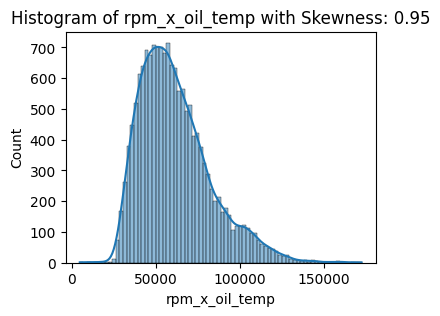

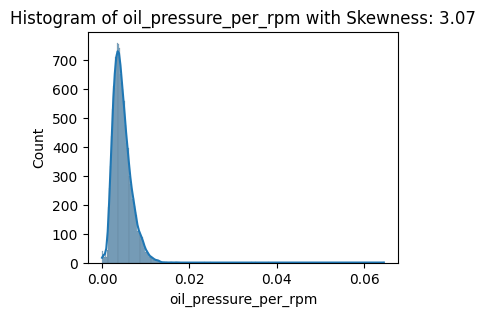

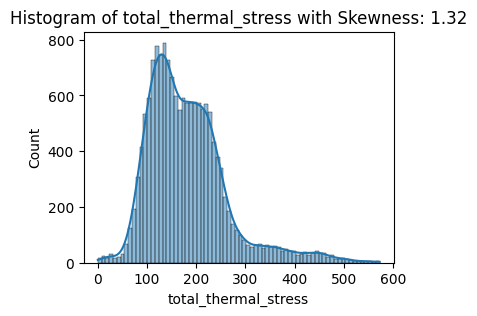

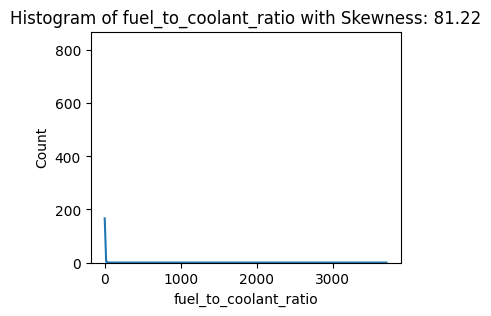

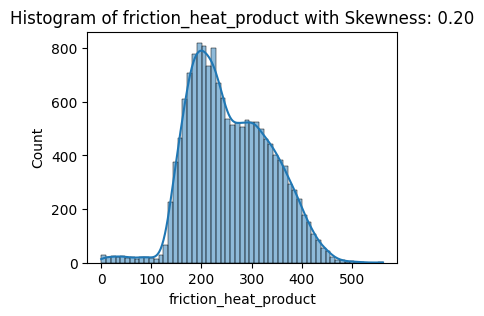

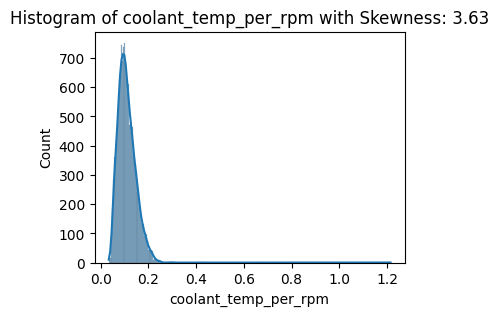

In [28]:
high_positive_skew=[]
high_negative_skew=[]
low_to_moderate_skew=[]
for col in derived_cols:
    # Calculate skewness
    skewness = df[col].skew()

    # Classify columns based on skewness
    if skewness > 1.3:
        high_positive_skew.append(col)
    elif skewness < -1.3:
        high_negative_skew.append(col)
    else:
        low_to_moderate_skew.append(col)

    # Print histogram and skewness value
    plt.figure(figsize=(4, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram of {col} with Skewness: {skewness:.2f}")
    plt.show()

In [29]:
high_positive_skew

['oil_pressure_per_rpm',
 'total_thermal_stress',
 'fuel_to_coolant_ratio',
 'coolant_temp_per_rpm']

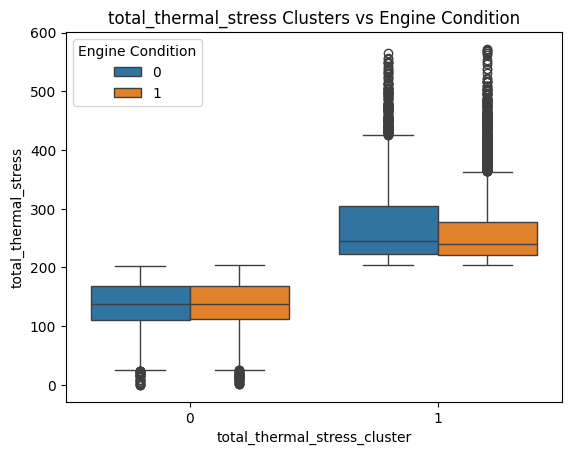

In [30]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['total_thermal_stress_cluster'] = kmeans.fit_predict(df[['total_thermal_stress']])

# Visualize cluster vs Engine Condition
sns.boxplot(data=df, x='total_thermal_stress_cluster', y='total_thermal_stress', hue='Engine Condition')
plt.title('total_thermal_stress Clusters vs Engine Condition')
plt.show()

In [31]:
pd.crosstab(df['total_thermal_stress_cluster'], df['Engine Condition'])

Engine Condition,0,1
total_thermal_stress_cluster,,
0,3793,6621
1,1981,3233


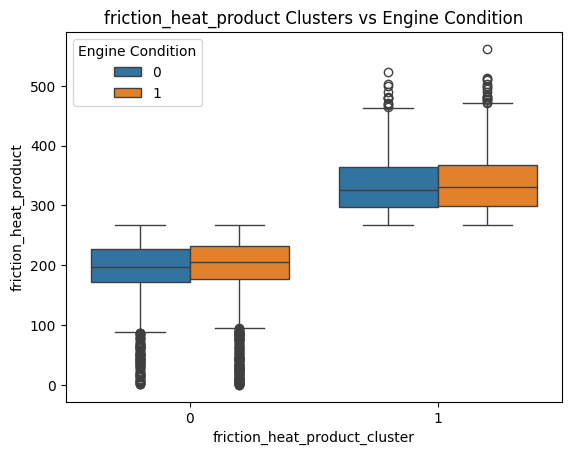

In [32]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['friction_heat_product_cluster'] = kmeans.fit_predict(df[['friction_heat_product']])

# Visualize cluster vs Engine Condition
sns.boxplot(data=df, x='friction_heat_product_cluster', y='friction_heat_product', hue='Engine Condition')
plt.title('friction_heat_product Clusters vs Engine Condition')
plt.show()

In [33]:
pd.crosstab(df['friction_heat_product_cluster'], df['Engine Condition'])

Engine Condition,0,1
friction_heat_product_cluster,,
0,3430,5623
1,2344,4231


In [34]:
df.drop(columns=['friction_heat_product_cluster','total_thermal_stress_cluster'],inplace=True)

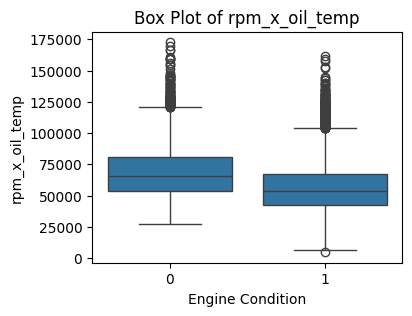

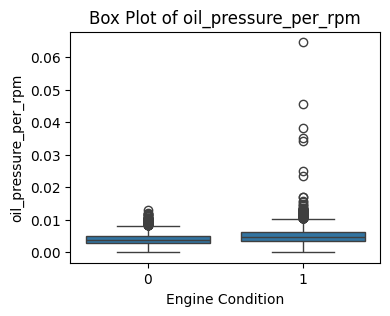

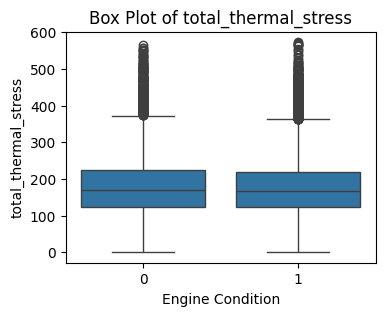

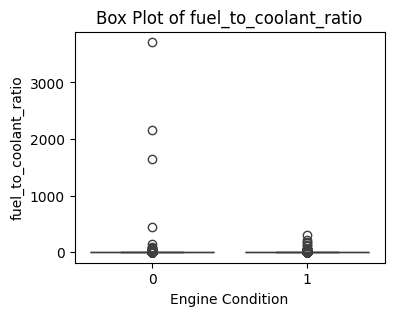

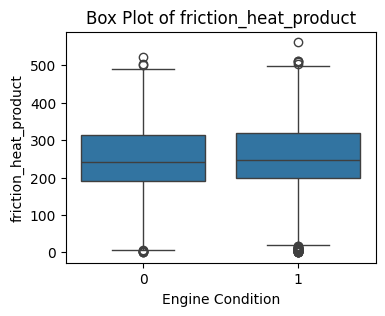

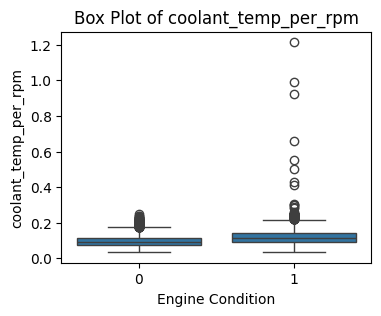

In [35]:
#df['Engine Condition']=y_train
for col in derived_cols:
    plt.figure(figsize=(4, 3))
    sns.boxplot(data=df, x='Engine Condition', y=col)
    plt.title(f'Box Plot of {col}')
    plt.show()

# Transformations

In [36]:
skewed=high_positive_skew1 + high_positive_skew

# Apply log transformation to each column
for col in skewed:
    df[col] = np.log(df[col] + 1)  # Adding 1 to avoid log(0) error

# Handling Outliers

In [37]:
x=df.drop(columns=['Engine Condition'])
y=df['Engine Condition']

In [38]:
x.columns

Index(['Engine rpm', 'Lub oil pressure', 'Fuel pressure', 'Coolant pressure',
       'lub oil temp', 'Coolant temp', 'rpm_x_oil_temp',
       'oil_pressure_per_rpm', 'total_thermal_stress', 'fuel_to_coolant_ratio',
       'friction_heat_product', 'coolant_temp_per_rpm'],
      dtype='object')

In [39]:
cap_cols=['rpm_x_oil_temp',
       'oil_pressure_per_rpm', 'total_thermal_stress', 'fuel_to_coolant_ratio', 'coolant_temp_per_rpm',
          'Engine rpm', 'Fuel pressure', 'Coolant pressure','lub oil temp','Coolant temp']

In [40]:
# Dictionary to store the 10th and 90th percentiles for each column
limits = {}

#Calculate and preserve the 10th and 90th percentiles from x_train
for col in cap_cols:
    lower_limit = x[col].quantile(0.01)
    upper_limit = x[col].quantile(0.90)
    limits[col] = (lower_limit, upper_limit)
#Cap outliers in x_train using the calculated percentiles
for col in cap_cols:
    lower_limit, upper_limit = limits[col]
    x[col] = x[col].clip(lower=lower_limit, upper=upper_limit)

# Correlation Matrix

<Axes: >

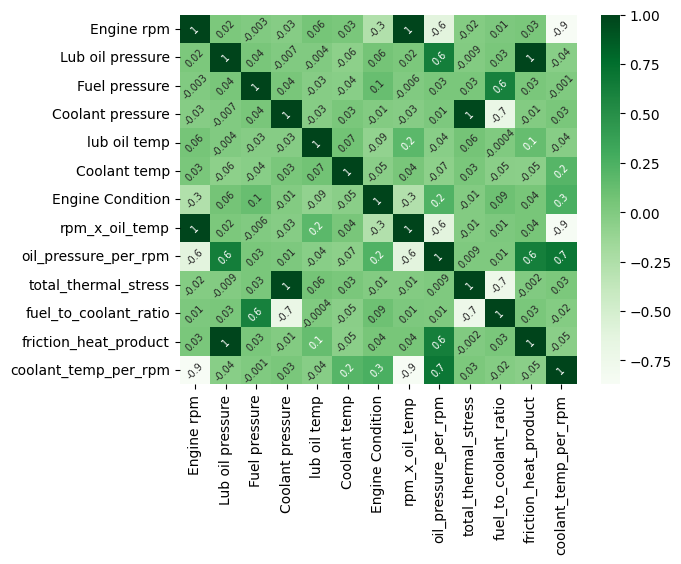

In [41]:
sns.heatmap(df.corr(),annot=True,fmt='.1g', annot_kws={"rotation": 45,"size": 7},cmap='Greens')

# Scaling

In [42]:
X=df.drop(columns=['Engine Condition'])
y=df['Engine Condition']

In [43]:
from sklearn.preprocessing import StandardScaler


features_to_scale=['Engine rpm', 'Lub oil pressure', 'Fuel pressure', 'Coolant pressure',
       'lub oil temp', 'Coolant temp', 'rpm_x_oil_temp',
       'oil_pressure_per_rpm', 'total_thermal_stress', 'fuel_to_coolant_ratio',
       'friction_heat_product', 'coolant_temp_per_rpm']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_scale, index=df.index)

In [44]:
X_scaled_df.shape

(15628, 12)

In [45]:
X_scaled2=X_scaled_df.copy(deep=True)

# Logistic Regression For Interpretability Check

## Model Building

In [46]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [47]:
# Generic function to calculate VIF of variables

def calculateVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [48]:
X_with_const = sm.add_constant(X_scaled_df)

In [49]:
glm_binom = sm.GLM(y, X_with_const, family=sm.families.Binomial())
glm_result = glm_binom.fit()

print(glm_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Engine Condition   No. Observations:                15628
Model:                            GLM   Df Residuals:                    15615
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9390.1
Date:                Mon, 21 Apr 2025   Deviance:                       18780.
Time:                        11:05:54   Pearson chi2:                 1.56e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1092
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.62

In [50]:
calculateVIF(X_with_const)

,Features,VIF
2,Lub oil pressure,664.05
11,friction_heat_product,661.26
7,rpm_x_oil_temp,621.23
1,Engine rpm,610.15
9,total_thermal_stress,67.12
4,Coolant pressure,30.18
10,fuel_to_coolant_ratio,26.87
5,lub oil temp,20.22
12,coolant_temp_per_rpm,17.22
8,oil_pressure_per_rpm,16.59


In [51]:
X_scaled_df.drop(columns=['Lub oil pressure'],inplace=True)

X_with_const = sm.add_constant(X_scaled_df)

glm_binom = sm.GLM(y, X_with_const, family=sm.families.Binomial())
glm_result = glm_binom.fit()

print(glm_result.summary())

calculateVIF(X_with_const)

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Engine Condition   No. Observations:                15628
Model:                            GLM   Df Residuals:                    15616
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9391.1
Date:                Mon, 21 Apr 2025   Deviance:                       18782.
Time:                        11:07:04   Pearson chi2:                 1.56e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1091
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.62

,Features,VIF
6,rpm_x_oil_temp,620.26
1,Engine rpm,609.33
8,total_thermal_stress,67.11
3,Coolant pressure,30.18
9,fuel_to_coolant_ratio,26.87
11,coolant_temp_per_rpm,16.97
7,oil_pressure_per_rpm,16.24
2,Fuel pressure,11.81
4,lub oil temp,10.42
10,friction_heat_product,8.04


In [52]:
X_scaled_df.drop(columns=['rpm_x_oil_temp'],inplace=True)

X_with_const = sm.add_constant(X_scaled_df)

glm_binom = sm.GLM(y, X_with_const, family=sm.families.Binomial())
glm_result = glm_binom.fit()

print(glm_result.summary())

calculateVIF(X_with_const)

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Engine Condition   No. Observations:                15628
Model:                            GLM   Df Residuals:                    15617
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9391.2
Date:                Mon, 21 Apr 2025   Deviance:                       18782.
Time:                        11:07:46   Pearson chi2:                 1.56e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1091
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.62

,Features,VIF
7,total_thermal_stress,67.11
3,Coolant pressure,30.18
8,fuel_to_coolant_ratio,26.87
10,coolant_temp_per_rpm,16.97
6,oil_pressure_per_rpm,16.24
2,Fuel pressure,11.81
9,friction_heat_product,8.04
1,Engine rpm,5.28
5,Coolant temp,1.92
4,lub oil temp,1.61


In [53]:
X_scaled_df.drop(columns=['total_thermal_stress'],inplace=True)

X_with_const = sm.add_constant(X_scaled_df)

glm_binom = sm.GLM(y, X_with_const, family=sm.families.Binomial())
glm_result = glm_binom.fit()

print(glm_result.summary())

calculateVIF(X_with_const)

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Engine Condition   No. Observations:                15628
Model:                            GLM   Df Residuals:                    15618
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9413.0
Date:                Mon, 21 Apr 2025   Deviance:                       18826.
Time:                        11:08:54   Pearson chi2:                 1.56e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1066
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.62

,Features,VIF
9,coolant_temp_per_rpm,16.97
6,oil_pressure_per_rpm,16.24
7,fuel_to_coolant_ratio,9.01
8,friction_heat_product,8.04
3,Coolant pressure,5.70
1,Engine rpm,5.28
2,Fuel pressure,4.64
5,Coolant temp,1.92
4,lub oil temp,1.14
0,const,1.00


In [54]:
X_scaled_df.drop(columns=['fuel_to_coolant_ratio'],inplace=True)

X_with_const = sm.add_constant(X_scaled_df)

glm_binom = sm.GLM(y, X_with_const, family=sm.families.Binomial())
glm_result = glm_binom.fit()

print(glm_result.summary())

calculateVIF(X_with_const)

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Engine Condition   No. Observations:                15628
Model:                            GLM   Df Residuals:                    15619
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9413.1
Date:                Mon, 21 Apr 2025   Deviance:                       18826.
Time:                        11:09:41   Pearson chi2:                 1.56e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1066
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.62

,Features,VIF
8,coolant_temp_per_rpm,16.97
6,oil_pressure_per_rpm,16.24
7,friction_heat_product,8.04
1,Engine rpm,5.28
5,Coolant temp,1.92
4,lub oil temp,1.14
2,Fuel pressure,1.01
0,const,1.00
3,Coolant pressure,1.00


In [55]:
X_scaled_df.drop(columns=['friction_heat_product'],inplace=True)

X_with_const = sm.add_constant(X_scaled_df)

glm_binom = sm.GLM(y, X_with_const, family=sm.families.Binomial())
glm_result = glm_binom.fit()

print(glm_result.summary())

calculateVIF(X_with_const)

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Engine Condition   No. Observations:                15628
Model:                            GLM   Df Residuals:                    15620
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9413.4
Date:                Mon, 21 Apr 2025   Deviance:                       18827.
Time:                        11:10:22   Pearson chi2:                 1.56e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1065
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6250 

,Features,VIF
7,coolant_temp_per_rpm,6.68
1,Engine rpm,5.11
6,oil_pressure_per_rpm,2.06
5,Coolant temp,1.40
2,Fuel pressure,1.01
4,lub oil temp,1.01
3,Coolant pressure,1.00
0,const,1.00


In [56]:
X_scaled_df.drop(columns=['coolant_temp_per_rpm'],inplace=True)

X_with_const = sm.add_constant(X_scaled_df)

glm_binom = sm.GLM(y, X_with_const, family=sm.families.Binomial())
glm_result = glm_binom.fit()

print(glm_result.summary())

calculateVIF(X_with_const)

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Engine Condition   No. Observations:                15628
Model:                            GLM   Df Residuals:                    15621
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9481.7
Date:                Mon, 21 Apr 2025   Deviance:                       18963.
Time:                        11:10:37   Pearson chi2:                 1.55e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09870
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5957 

,Features,VIF
6,oil_pressure_per_rpm,1.64
1,Engine rpm,1.63
2,Fuel pressure,1.01
5,Coolant temp,1.01
4,lub oil temp,1.01
0,const,1.00
3,Coolant pressure,1.00


This model shows all p values less than 0.05 and all VIFs below 5.

This logistic regression model estimates the probability that an automotive engine is in bad condition (Engine Condition = 0) based on real-time sensor and performance data. The coefficients reflect how each variable affects the log-odds of an engine being in good health (Engine Condition = 1).

Below is the interpretation of each variable:

1. Engine RPM

Coefficient = –0.4040

Higher engine RPM is associated with a lower probability of good engine health.
Bad engines in the dataset tend to operate at unusually high RPMs, possibly due to:

- Poor idle control,

- Compensatory behavior by the ECU (engine control unit),

- Or mechanical inefficiencies causing unstable engine behavior.
Thus, elevated RPM may serve as a symptom of engine distress, rather than high performance.



2. Fuel Pressure

Coefficient = +0.2704

Higher fuel pressure is linked to a greater probability of good engine health.
This suggests that well-functioning engines maintain consistent and adequate fuel pressure to ensure efficient combustion.
Conversely, lower fuel pressure could be symptomatic of:

- Fuel pump degradation,

- Injector clogging,

- Or compensation in faulty engines.



3. Coolant Pressure

Coefficient = –0.0548

Higher coolant pressure is slightly associated with lower engine health.
This could indicate:

- Overheating due to poor coolant flow,

- Blocked passages or a clogged radiator,

- Or pressure buildup from ineffective heat dissipation.



4. Lubricant Oil Temperature

Coefficient = –0.1662

Higher oil temperatures reduce the likelihood of good engine health.
This reflects elevated internal friction, possible inadequate lubrication, or thermal stress — all of which are indicators of engine wear or inefficiency.
Healthy engines tend to operate within a stable and safe oil temperature range.



5. Coolant Temperature

Coefficient = –0.0523

Increased coolant temperature is mildly associated with lower engine health.
While some increase in coolant temperature is normal during engine operation, excessive levels may point to:

- Overheating,

- Thermostat failure,

- Or clogged coolant flow.

Thus, this variable acts as a subtle risk factor.



6. Oil Pressure per RPM (Lubricant Oil Pressure / Engine RPM)

Coefficient = +0.3014

A higher oil pressure per unit of RPM is strongly associated with good engine health.
This feature reflects an engine's ability to maintain oil pressure effectively as it operates at higher speeds, suggesting a well-maintained lubrication system and good mechanical integrity.
It emerged as one of the most important predictors in the model.

 Oil Pressure per RPM was a derived feature. It emerged as a good positive predictor of engine health, indicating that engines capable of sustaining oil pressure across RPMs tend to be in better condition.

Protective Indicators (associated with good engine health):

- High oil pressure per RPM

- Adequate and stable fuel pressure

Risk Indicators (associated with poor engine health):

- Elevated engine RPM

- High lubricant oil temperature

- High coolant temperature and pressure

## Fitting Test Data

In [57]:
x_test2=x_test.copy(deep=True)
y_test2=y_test.copy(deep=True)

In [58]:
skewed

['Coolant pressure',
 'lub oil temp',
 'oil_pressure_per_rpm',
 'total_thermal_stress',
 'fuel_to_coolant_ratio',
 'coolant_temp_per_rpm']

In [59]:
caps=[col for col in cap_cols if col in X_scaled2.columns]


In [60]:
# load/stress
x_test2['rpm_x_oil_temp'] = x_test2['Engine rpm'] * x_test2['lub oil temp']
# oil pressure per rpm
x_test2['oil_pressure_per_rpm'] = x_test2['Lub oil pressure'] / (x_test2['Engine rpm'] + 1e-5)
# total thermal stress
x_test2['total_thermal_stress'] = x_test2['Coolant pressure'] * x_test2['lub oil temp']
# fuel_to_coolant_ratio
x_test2['fuel_to_coolant_ratio'] = x_test2['Fuel pressure'] / (x_test2['Coolant pressure'] + 1e-5)
# friction heat product
x_test2['friction_heat_product'] = x_test2['Lub oil pressure'] * x_test2['lub oil temp']
# Overheating under load - coolant efficiency measure
x_test2['coolant_temp_per_rpm'] = x_test2['Coolant temp'] / (x_test2['Engine rpm'] + 1e-5)

In [61]:
for col in skewed:
    x_test2[col] = np.log(x_test2[col] + 1)  # Adding 1 to avoid log(0) error

In [62]:
#x_test2['friction_heat_product'] = x_test2['Lub oil pressure'] * x_test2['lub oil temp']

# Cap outliers in test set using the limits from training data
for col in cap_cols:
    lower_limit, upper_limit = limits[col]
    x_test2[col] = x_test2[col].clip(lower=lower_limit, upper=upper_limit)

In [63]:
# scaling
X_test_scaled = scaler.transform(x_test2)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features_to_scale, index=x_test2.index)

In [64]:
X_scaled_df.columns

Index(['Engine rpm', 'Fuel pressure', 'Coolant pressure', 'lub oil temp',
       'Coolant temp', 'oil_pressure_per_rpm'],
      dtype='object')

In [65]:
X_test_scaled2=X_test_scaled_df.copy(deep=True)

In [66]:
X_test_scaled_df=X_test_scaled_df[X_scaled_df.columns]
X_test_scaled_df.head(2)

,Engine rpm,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,oil_pressure_per_rpm
2830,-0.591999,1.298168,0.564331,-0.575308,0.130714,-0.234165
16425,0.238422,-0.297857,0.269999,-1.259155,-1.187363,0.040424


In [67]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

In [68]:
x_test2_const = sm.add_constant(X_test_scaled_df)

In [69]:
y_train_pred_prob = glm_result.predict(X_with_const)
y_test_pred_prob = glm_result.predict(x_test2_const)

In [70]:
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

Test Set Evaluation
Accuracy:  0.6583
Precision: 0.6755
Recall:    0.8814
F1 Score:  0.7648
ROC-AUC:   0.6955

Train Set Evaluation
Accuracy:  0.6638
Precision: 0.6839
Recall:    0.8681
F1 Score:  0.7650
ROC-AUC:   0.6894


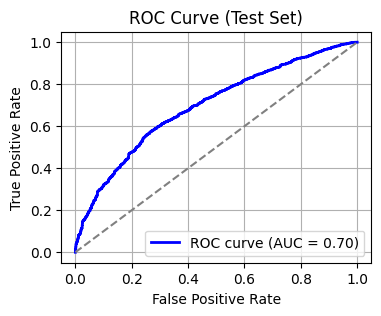

In [71]:
# Evaluate on test set
print("Test Set Evaluation")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_pred_prob):.4f}")

# Evaluate on train set (optional, for comparison)
print("\nTrain Set Evaluation")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score:  {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_pred_prob):.4f}")

# Plot ROC curve for test set
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_test_pred_prob):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The logistic regression model tells that the core 6 features are the most necessary but some complexities still remain unexplained.

In [72]:
X_scaled_df.columns

Index(['Engine rpm', 'Fuel pressure', 'Coolant pressure', 'lub oil temp',
       'Coolant temp', 'oil_pressure_per_rpm'],
      dtype='object')

In [73]:
x.shape

(15628, 12)

In [74]:
x_test2.shape

(3907, 12)

In [75]:
x.columns

Index(['Engine rpm', 'Lub oil pressure', 'Fuel pressure', 'Coolant pressure',
       'lub oil temp', 'Coolant temp', 'rpm_x_oil_temp',
       'oil_pressure_per_rpm', 'total_thermal_stress', 'fuel_to_coolant_ratio',
       'friction_heat_product', 'coolant_temp_per_rpm'],
      dtype='object')

Refering to the correlation matrix and removing the highest correlated features. Keeping the core 6 features as selected by the logistic regression model, and adding some more.

In [76]:
# X_scaled2=X_scaled2[['Engine rpm', 'Fuel pressure', 'Coolant pressure', 'lub oil temp',
#        'Coolant temp', 'friction_heat_product','fuel_to_coolant_ratio','oil_pressure_per_rpm']]

# X_test_scaled2=X_test_scaled2[['Engine rpm', 'Fuel pressure', 'Coolant pressure', 'lub oil temp',
#        'Coolant temp', 'friction_heat_product','fuel_to_coolant_ratio','oil_pressure_per_rpm']]


X_scaled2=X_scaled2[['Engine rpm', 'Fuel pressure', 'Coolant pressure', 'lub oil temp',
       'Coolant temp', 'oil_pressure_per_rpm']]

X_test_scaled2=X_test_scaled2[['Engine rpm', 'Fuel pressure', 'Coolant pressure', 'lub oil temp',
       'Coolant temp', 'oil_pressure_per_rpm']]

# XGBoost Model For Prediction

In [135]:
# Prepare stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Base XGBoost model
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid
param_grid = {
    'max_depth': [1,2],
    'subsample': [0.8,0.9,1],
    'n_estimators':[100]
    #'min_child_weight': [3,4]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1
)


# Fit grid search
grid_search.fit(X_scaled2, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# Train predictions
y_train_pred = best_model.predict(X_scaled2)
y_train_prob = best_model.predict_proba(X_scaled2)[:, 1]

# Test predictions
y_test_pred = best_model.predict(X_test_scaled2)
y_test_prob = best_model.predict_proba(X_test_scaled2)[:, 1]

# Classification reports
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test2, y_test_pred))

# ROC-AUC scores
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test2, y_test_prob)

print(f"\nROC-AUC (Train): {train_auc:.4f}")
print(f"ROC-AUC (Test):  {test_auc:.4f}")



Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best Parameters: {'max_depth': 1, 'n_estimators': 100, 'subsample': 0.8}

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.60      0.39      0.47      5774
           1       0.70      0.85      0.77      9854

    accuracy                           0.68     15628
   macro avg       0.65      0.62      0.62     15628
weighted avg       0.66      0.68      0.66     15628


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.58      0.32      0.42      1444
           1       0.68      0.86      0.76      2463

    accuracy                           0.66      3907
   macro avg       0.63      0.59      0.59      3907
weighted avg       0.64      0.66      0.63      3907


ROC-AUC (Train): 0.7108
ROC-AUC (Test):  0.7004


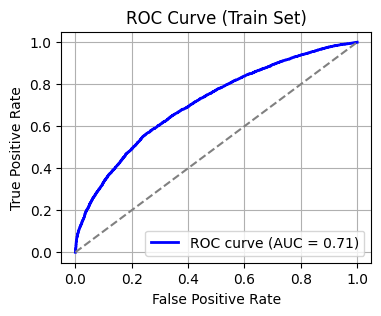

In [136]:
# Plot ROC curve for train set
fpr, tpr, _ = roc_curve(y_train, y_train_prob)
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_train, y_train_prob):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

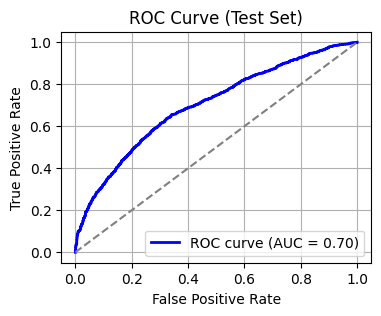

In [137]:
# Plot ROC curve for test set
fpr, tpr, _ = roc_curve(y_test2, y_test_prob)
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test2, y_test_prob):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Conclusion

This project successfully explored the development of a predictive system for automotive engine health classification using real-world sensor and operational data.

A logistic regression model was initially fitted to provide a baseline, offering interpretable insights into key factors influencing engine performance. Feature selection was performed rigorously using statistical significance (p-values) and multicollinearity checks (VIF), ultimately narrowing the input space to six core features with meaningful physical relevance.

Key Features & Their Effects on Engine Health:

1. Engine RPM

Coefficient = –0.4040

Higher engine RPM is associated with a lower probability of good engine health.
Bad engines in the dataset tend to operate at unusually high RPMs, possibly due to:

- Poor idle control,

- Compensatory behavior by the ECU (engine control unit),

- Or mechanical inefficiencies causing unstable engine behavior.
Thus, elevated RPM may serve as a symptom of engine distress, rather than high performance.



2. Fuel Pressure

Coefficient = +0.2704

Higher fuel pressure is linked to a greater probability of good engine health.
This suggests that well-functioning engines maintain consistent and adequate fuel pressure to ensure efficient combustion.
Conversely, lower fuel pressure could be symptomatic of:

- Fuel pump degradation,

- Injector clogging,

- Or compensation in faulty engines.



3. Coolant Pressure

Coefficient = –0.0548

Higher coolant pressure is slightly associated with lower engine health.
This could indicate:

- Overheating due to poor coolant flow,

- Blocked passages or a clogged radiator,

- Or pressure buildup from ineffective heat dissipation.



4. Lubricant Oil Temperature

Coefficient = –0.1662

Higher oil temperatures reduce the likelihood of good engine health.
This reflects elevated internal friction, possible inadequate lubrication, or thermal stress — all of which are indicators of engine wear or inefficiency.
Healthy engines tend to operate within a stable and safe oil temperature range.



5. Coolant Temperature

Coefficient = –0.0523

Increased coolant temperature is mildly associated with lower engine health.
While some increase in coolant temperature is normal during engine operation, excessive levels may point to:

- Overheating,

- Thermostat failure,

- Or clogged coolant flow.

Thus, this variable acts as a subtle risk factor.



6. Oil Pressure per RPM (Lubricant Oil Pressure / Engine RPM)

Coefficient = +0.3014

A higher oil pressure per unit of RPM is strongly associated with good engine health.
This feature reflects an engine's ability to maintain oil pressure effectively as it operates at higher speeds, suggesting a well-maintained lubrication system and good mechanical integrity.
It emerged as one of the most important predictors in the model.

 Oil Pressure per RPM was a derived feature. It emerged as a good positive predictor of engine health, indicating that engines capable of sustaining oil pressure across RPMs tend to be in better condition.



Protective Indicators (associated with good engine health):

- High oil pressure per RPM

- Adequate and stable fuel pressure

Risk Indicators (associated with poor engine health):

- Elevated engine RPM (crossing 1400 rpm)

- High lubricant oil temperature (crossing 77 units)

- High coolant temperature and pressure (crossing 80 units and 4 units respectively)


[Note: Units for temperature and pressure were not explicitly defined in the dataset. All thresholds are based on relative trends observed in the data.]

Given the binary nature of the problem, model evaluation extended beyond simple accuracy to include ROC-AUC, which provides a more nuanced view of classification quality. To further improve predictive performance, a gradient boosting model (XGBoost) was applied. This led to improvement in the accuracy from the baseline model.

This work highlights the practical application of machine learning in the automotive domain and showcases a balance between model interpretability and predictive capability — an essential consideration for real-world deployment and decision-making.